In [1]:
from config import *
from utils import *

import os
import pickle
import collections
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, matthews_corrcoef

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import subprocess

In [2]:
# Consider only repair genotypes with at least COUNT_THRES observed transcripts for computing PSI values.
COUNT_THRES = 50

In [3]:
indel_splice_precas_count_map = load_bc_seq(INDEL_SPLICE_PRECAS_COUNT_MAP)
indel_splice_postcas_count_map = load_bc_seq(INDEL_SPLICE_POSTCAS_COUNT_MAP)
gt_splice_count_map = load_bc_seq(GT_SPLICE_COUNT_MAP)
gt_precas_splice_count_map = load_bc_seq(GT_PRECAS_SPLICE_COUNT_MAP)
predicted_gt_indel_dist_map = load_var(PREDICTED_GT_INDEL_DIST_MAP)

# Empirical Exon B Retention Frequencies ($\Psi_R$, $\Psi_G$, and WT $\Psi$)
$\Psi = \frac{T_B + 1}{T_B + T_C + 2}$

In [4]:
PSEUDO_COUNT = 1

def get_B_retention_f(indel_splice_count_map):
    result = []
    total_counts = []
    for indel, splice_count_map in indel_iterator(indel_splice_count_map):
        if not (indel[1] == 'N' or indel[1] in DELETION_SIGNATURES or (indel[1] in INSERTION_SIGNATURES and indel[2] == 1)):
            continue
            
        C_f = (splice_count_map['C'] + PSEUDO_COUNT) / (splice_count_map['C'] + splice_count_map['B'] + 2*PSEUDO_COUNT)
        result.append(1 - C_f)
        total_counts.append(splice_count_map['C'] + splice_count_map['B'])
    return result, total_counts


def get_aggBf_scores(gt_splice_count_map):
    aggBf_scores = []
    aggBf_counts = []
    for gt in gt_splice_count_map.keys():
        m = gt_splice_count_map[gt]
        C_f = (m['C'] + PSEUDO_COUNT) / (m['C'] + m['B'] + 2*PSEUDO_COUNT)
        aggBf_scores.append(1 - C_f)
        aggBf_counts.append(m['C'] + m['B'])
    return aggBf_scores, aggBf_counts

In [5]:
splice_precas_Bf, splice_precas_total = get_B_retention_f(indel_splice_precas_count_map)
splice_postcas_Bf, splice_postcas_total = get_B_retention_f(indel_splice_postcas_count_map)
aggBf_scores, aggBf_counts = get_aggBf_scores(gt_splice_count_map)

# MaxEntScan Accuracy

In [6]:
def predict_MESScores(indel_splice_count_map):
    seq_23mers = []
    for indel, splice_count_map in indel_iterator(indel_splice_count_map):
        if not(indel[1] == 'N' or indel[1] in DELETION_SIGNATURES or (indel[1] in INSERTION_SIGNATURES and indel[2] == 1)):
            continue
            
        seq = exp_tid_target_map[exp_gid_tid_map[splice_count_map['gid']]]
        splice_idx = splice_count_map['spliceidx']
        prefix = 'TACCAGCTGCCCTCGTCGAC'
        suffix = 'TGATTACACATATAGACACGC'
        seq = prefix + seq + suffix
        splice_idx += len(prefix)
        if splice_idx < 20:
            seq = 'N' * (splice_idx - 20) + seq
        seq_23mer = seq[splice_idx - 20:splice_idx + 3]
        assert len(seq_23mer) == 23
        seq_23mers.append(seq_23mer)
    with open(os.path.join(MAXENTSCAN_DIR, 'query'), 'w') as f:
        f.write('\n'.join(seq_23mers))
    
    output = subprocess.check_output(
        ['perl', 'score3.pl', 'query'],
        universal_newlines=True,
        cwd=MAXENTSCAN_DIR
    )
    return [float(r.split('\t')[1]) for r in output.strip().split('\n')]

In [7]:
splice_postcas_MESScores = predict_MESScores(indel_splice_postcas_count_map)

In [8]:
def plot_Bf_vs_prediction(bf, scores, count_total):
    bf = np.array(bf)
    scores = np.array(scores)
    count_total = np.array(count_total)
    
    bf = bf[count_total > COUNT_THRES]
    scores = scores[count_total > COUNT_THRES]
    print(len(scores))
    ax = sns.jointplot(scores, bf, kind="reg").annotate(scipy.stats.pearsonr)
    return ax

def plot_Bf_vs_MESScore(bf, scores, count_total):
    ax = plot_Bf_vs_prediction(bf, scores, count_total)
    ax.set_axis_labels("MaxEntScan 3' Score", 'Frequency of Exon B Retention')
    ax.ax_marg_y.set_ylim(-0.01, 1.01)
    plt.show()

## S2 Fig

2113


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


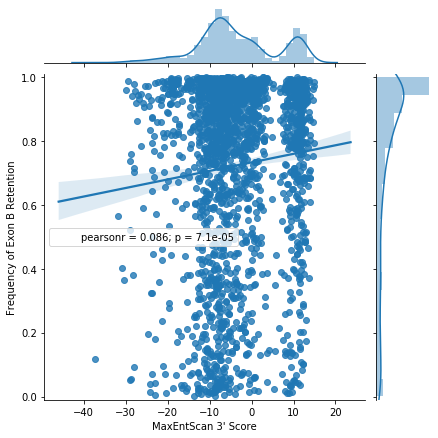

In [9]:
plot_Bf_vs_MESScore(splice_postcas_Bf, splice_postcas_MESScores, splice_postcas_total)

# MMSplice's Intron, Acceptor, Exon Module Accuracy

In [10]:
mmsplice_precas_df = pd.read_csv(MMSPLICE_PRECAS_DF_PATH)
mmsplice_postcas_df = pd.read_csv(MMSPLICE_POSTCAS_DF_PATH)

In [11]:
# Generates indels x predictions matrix
def mmsplice_df_to_scores_df(df, indel_splice_count_map, progress=True):
    indel_splice_count_map_list = list(indel_iterator(indel_splice_count_map))
    scores = []
    iterator = tqdm(range(len(indel_splice_count_map_list))) if progress else range(len(indel_splice_count_map_list))

    for i in iterator:
        p = df[df['gene_id'] == 'g' + str(i)]
        indel = indel_splice_count_map_list[i][0]
        if indel[1] == 'N' or indel[1] in DELETION_SIGNATURES or (indel[1] in INSERTION_SIGNATURES and indel[2] == 1):
            exon_b_preds = p[p['exon_id'] == 'e' + str(i) + 'BC'].iloc[0]
            scores.append(exon_b_preds[[
                'alt_acceptorIntron',
                'alt_acceptor',
                'alt_exon'
            ]].values)
    return np.array(scores)

In [12]:
X_postcas = mmsplice_df_to_scores_df(mmsplice_postcas_df, indel_splice_postcas_count_map, True)
X_precas = mmsplice_df_to_scores_df(mmsplice_precas_df, indel_splice_precas_count_map, True)

In [13]:
def generate_X_y(X_postcas, X_precas, 
                 bf_postcas, bf_precas, 
                 postcas_count, precas_count,
                 indel_splice_postcas_count_map,
                 indel_splice_precas_count_map):
    indel_splice_postcas_count_map_list = list(indel_iterator(indel_splice_postcas_count_map))
    indel_splice_precas_count_map_list = list(indel_iterator(indel_splice_precas_count_map))
    
    # Remove skipping frequencies calculated from low data support
    bf_postcas = np.array(bf_postcas)
    bf_precas = np.array(bf_precas)
    postcas_count = np.array(postcas_count)
    precas_count = np.array(precas_count)
    postcas_gids = np.array([count_map['gid'] for indel, count_map in indel_splice_postcas_count_map_list])
    precas_gids = np.array([count_map['gid'] for indel, count_map in indel_splice_precas_count_map_list])
    
    bf_postcas = bf_postcas[postcas_count > COUNT_THRES]
    X_postcas = X_postcas[postcas_count > COUNT_THRES, :]
    postcas_gids = postcas_gids[postcas_count > COUNT_THRES]
    indels_postcas = [indel_splice_postcas_count_map_list[i][0] for i, c in enumerate(postcas_count) if c > COUNT_THRES]
    bf_precas = bf_precas[precas_count > COUNT_THRES]
    X_precas = X_precas[precas_count > COUNT_THRES, :]
    precas_gids = precas_gids[precas_count > COUNT_THRES]
    indels_precas = [indel_splice_precas_count_map_list[i][0] for i, c in enumerate(precas_count) if c > COUNT_THRES]
    
    precounts = precas_count[precas_count > COUNT_THRES]
    postcounts = postcas_count[postcas_count > COUNT_THRES]

    d = {
        'acceptorIntronScore': list(X_postcas[:, 0]),
        'acceptorScore': list(X_postcas[:, 1]),
        'exonScore': list(X_postcas[:, 2])
    }

    d_precas = {
        'acceptorIntronScore': list(X_precas[:, 0]),
        'acceptorScore': list(X_precas[:, 1]),
        'exonScore': list(X_precas[:, 2])
    }

    bf_postcas = logit(bf_postcas)
    bf_precas = logit(bf_precas)

    
    X = pd.DataFrame(d)
    y = np.array(list(bf_postcas))
    gids = np.array(list(postcas_gids))
    counts = list(postcounts)
    
    gids_precas = np.array(list(precas_gids))
    counts_precas = list(precounts)
    
    return X, y, gids, counts, indels_postcas, pd.DataFrame(d_precas), bf_precas, gids_precas, counts_precas

In [14]:
X, y, gids, counts, indels, Xprecas, y_precas, gids_precas, counts_precas = generate_X_y(X_postcas, X_precas, 
                                                                     splice_postcas_Bf, splice_precas_Bf, 
                                                                     splice_postcas_total, splice_precas_total,
                                                                     indel_splice_postcas_count_map,
                                                                     indel_splice_precas_count_map)

In [15]:
print(X.shape, y.shape)

(2113, 3) (2113,)


In [16]:
len(set(gids))

1063

In [17]:
len(set(exp_gid_tid_map[g] for g in set(gids)))

791

In [18]:
def plot_y_vs_prediction(bf, scores):    
    g = sns.jointplot(scores, bf, height=5, kind="reg",joint_kws = {'scatter_kws':dict(alpha=0.5)}).annotate(scipy.stats.pearsonr)
    g.set_axis_labels("$\Psi$ WT (before Cas9)", "$\Psi_G$ (after Cas9)", fontsize=16)
    return g

## S2 Figs

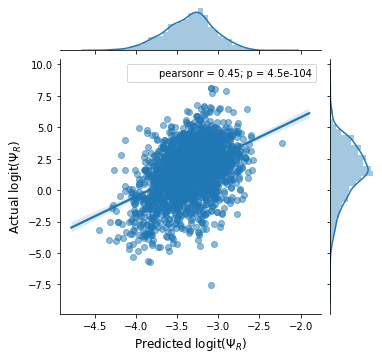

In [19]:
g = plot_y_vs_prediction(y, X.acceptorIntronScore)
g.set_axis_labels("Predicted logit($\Psi_R$)", "Actual logit($\Psi_R$)", fontsize=12)
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_intron.png'), dpi=300, bbox_inches='tight')
plt.show()

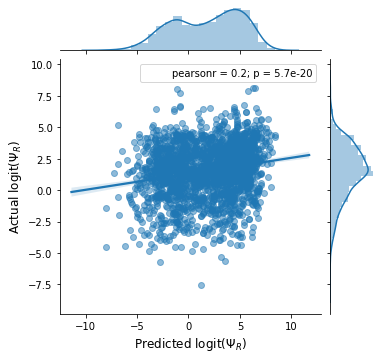

In [20]:
g = plot_y_vs_prediction(y, X.acceptorScore)
g.set_axis_labels("Predicted logit($\Psi_R$)", "Actual logit($\Psi_R$)", fontsize=12)
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_acceptor.png'), dpi=300, bbox_inches='tight')
plt.show()

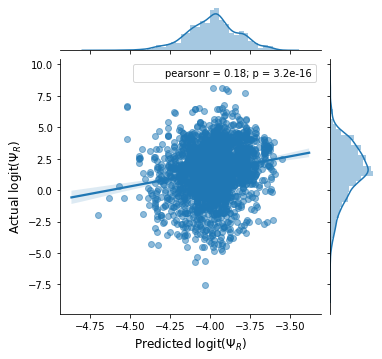

In [21]:
g = plot_y_vs_prediction(y, X.exonScore)
g.set_axis_labels("Predicted logit($\Psi_R$)", "Actual logit($\Psi_R$)", fontsize=12)
plt.savefig(os.path.join(IMAGES_DIR, 'mmsplice_exon.png'), dpi=300, bbox_inches='tight')
plt.show()

# wMMSplice 10-fold CV Training and Evaluation

In [22]:
gid_gt_idx_precas_map = {exp_grna_gid_map[gt[0]][0]:(gt, i) for i, gt in enumerate(gt_precas_splice_count_map.keys())}
gid_gt_idx_postcas_map = {exp_grna_gid_map[gt[0]][0]:(gt, i) for i, gt in enumerate(gt_splice_count_map.keys())}

In [23]:
def gid_to_y(gid, model, ablate_indelphi=False, ablate_wmmsplice=False):
    if gid not in gid_gt_idx_postcas_map:
        return None, None, None
    
    postcas_csv = os.path.join(MMSPLICE_GT_DF_DIR, str(gid) + '.csv')
    if not os.path.exists(postcas_csv):
        return None, None, None
    
    gt = gid_gt_idx_postcas_map[gid][0]
    cutsite = get_cutsite(*gt)
    idx = gid_gt_idx_postcas_map[gid][1]
    indel_splice_count_map = collections.defaultdict(lambda: collections.defaultdict(int))
    distribution = predicted_gt_indel_dist_map[gt]
    for deletion_size in range(1, MAX_INDEL_LEN + 1):
        for genotype_pos in distribution[-deletion_size]:
            if distribution[-deletion_size][genotype_pos] > 0:
                indel = ('', 'DS', deletion_size, genotype_pos, cutsite)
                indel_splice_count_map[indel]['gid'] = gid
                indel_splice_count_map[indel]['indelphifreq'] = distribution[-deletion_size][genotype_pos]
    for base in 'AGTC':
        if distribution[1][base] > 0:
            indel = ('', 'IS', 1, base, cutsite)
            indel_splice_count_map[indel]['gid'] = gid
            indel_splice_count_map[indel]['indelphifreq'] = distribution[1][base]
    
    if not ablate_wmmsplice:
        mmsplice_df = pd.read_csv(postcas_csv)
        X = mmsplice_df_to_scores_df(mmsplice_df, indel_splice_count_map, progress=False)
        y = model.predict(X)
    else:
        # Produce random predictions
        y = np.random.random_sample(len(list(indel_iterator(indel_splice_count_map))))
        
    if not ablate_indelphi:
        w = [splice_count_map['indelphifreq'] for indel, splice_count_map in indel_iterator(indel_splice_count_map)]
    else:
        # Uniform weights instead of indelphi frequency weights
        w = None
        
    return np.average(y, weights=w), aggBf_scores[idx], aggBf_counts[idx]

In [24]:
def cross_val_predict(X, y, gids, counts, indels, cv=10, ablate_indelphi=False, ablate_wmmsplice=False):
    np.random.seed(42)
    preds = []
    actual = []
    support = []
    y_indel = []
    y_gids = []
    gt_preds = []
    gt_actual = []
    gt_support = []
    gt_indels = []
    gt_gids = []
    gt_p_folds = []
    gt_y_folds = []
    groups = GroupKFold(n_splits=cv)
    for train_index, test_index in groups.split(X, y, gids):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        counts_train, counts_test = counts[train_index], counts[test_index]
        gids_test = gids[test_index]
        indels_test = [indels[i] for i in test_index]
        gids_train = gids[train_index]
        indels_train = [indels[i] for i in train_index]
        
        model = LinearRegression()
        if not ablate_wmmsplice:
            model.fit(X_train, y_train)
            preds += list(model.predict(X_test))
            actual += list(y_test)
            support += list(counts_test)
            y_indel += indels_test
            y_gids += list(gids_test)
        
        pf = []
        yf = []
        for gid in tqdm(set(gids_test)):
            gt_pred, gt_y, gt_counts = gid_to_y(gid, model, ablate_indelphi, ablate_wmmsplice)
            if gt_pred is None:
                continue
                
            pf.append(gt_pred)
            yf.append(gt_y)
                
            gt_preds.append(gt_pred)
            gt_actual.append(gt_y)
            gt_support.append(gt_counts)
            gt_gids.append(gid)
            
        gt_p_folds.append(pf)
        gt_y_folds.append(yf)
        
    return preds, actual, support, y_indel, gt_preds, gt_actual, gt_support, gt_indels, y_gids, gt_gids, gt_p_folds, gt_y_folds 

In [25]:
# 10-fold CV for training and evaluating wMMSplice
y_preds, y_actual, support, y_indels, gt_preds, gt_actual, gt_support, gt_indels, y_gids, gt_gids, gt_p_folds, gt_y_folds = cross_val_predict(X, y, gids, np.array(counts), indels, 10, False, False)

In [26]:
# Perturbation study: wMMSplice predictions ablated (replaced with random values between 0 and 1)
_, _, _, _, gt_preds_abwmmsplice, gt_actual_abwmmsplice, gt_support_abwmmsplice, _, _, gt_gids_abwmmsplice, _, _ = cross_val_predict(X, y, gids, np.array(counts), indels, 10, False, True)

In [27]:
# Perturbation study: both inDelphi and wMMSplice ablated
_, _, _, _, gt_preds_abboth, gt_actual_abboth, gt_support_abboth, _, _, gt_gids_abboth, _, _ = cross_val_predict(X, y, gids, np.array(counts), indels, 10, True, True)

In [28]:
# Perturbation study: inDelphi frequency predictions ablated (set to uniform frequency)
_, _, _, _, gt_preds_abindelphi, gt_actual_abindelphi, gt_support_abindelphi, _, _, gt_gids_abindelphi, _, _ = cross_val_predict(X, y, gids, np.array(counts), indels, 10, True, False)

In [29]:
def plot_logit(y_preds, y_actual):       
    fig = plt.figure(figsize=(5,5))
    print(scipy.stats.pearsonr(y_actual, y_preds))
    plt.scatter(y_preds, y_actual, alpha=0.3)
    limx, limy = -8, 9
    plt.xlim((limx, limy))
    plt.ylim((limx, limy))
    plt.plot([limx, limy], [limx, limy], color='black', linestyle='dashed')
    plt.title(str(len(y_preds)) + ' Indels Post Cas9\nPearson $r = ' + "{:.2f}".format(scipy.stats.pearsonr(y_actual, y_preds)[0], 2) + '$', fontsize=12)
    plt.xlabel("Predicted logit($\Psi_R$)", fontsize=12)
    plt.ylabel("Actual logit($\Psi_R$)", fontsize=12)
    plt.axes().set_aspect('equal')
    plt.savefig(os.path.join(IMAGES_DIR, 'wmmsplice_logit.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_interpretable(y_preds, y_actual):
    y_preds = expit(np.array(y_preds))
    y_actual = expit(np.array(y_actual))
    fig = plt.figure(figsize=(5,5))
    print(scipy.stats.pearsonr(y_actual, y_preds))
    plt.scatter(y_preds, y_actual, alpha=0.3)
    limx, limy = 0, 1
    plt.xlim((limx, limy))
    plt.ylim((limx, limy))
    plt.plot([limx, limy], [limx, limy], color='black', linestyle='dashed')
    plt.title(str(len(y_preds)) + 
              " Repair Outcomes\nPearson's $r = " +
              "{:.2f}".format(scipy.stats.pearsonr(y_actual, y_preds)[0], 2) + 
              ', p = '+"{:.2E}".format(scipy.stats.pearsonr(y_actual, y_preds)[1]) +
              '$')
    plt.xlabel("Predicted $\Psi_R$")
    plt.ylabel("Actual $\Psi_R$")
    plt.axes().set_aspect('equal')
    plt.savefig(os.path.join(IMAGES_DIR, 'wmmsplice_pred.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
def plot_normal(y_preds, y_actual, gids):
    fig = plt.figure(figsize=(5,5))
    plt.axes().set_aspect('equal')
    print(scipy.stats.pearsonr(y_actual, expit(np.array(y_preds))))
    x, y = expit(np.array(y_preds)), y_actual
    print(len(x), len(y))
    indel_splice_precas_count_map_list = list(indel_iterator(indel_splice_precas_count_map))
    precas_gid_bf = {count_map['gid']:splice_precas_Bf[i] 
                     for i, (indel, count_map) in enumerate(indel_splice_precas_count_map_list)}
    exclude_gid = set(gids) - precas_gid_bf.keys()
    x_inc = [x[i] for i, gid in enumerate(gids) if gid not in exclude_gid]
    x_ex = [x[i] for i, gid in enumerate(gids) if gid in exclude_gid]
    y_inc = [y[i] for i, gid in enumerate(gids) if gid not in exclude_gid]
    y_ex = [y[i] for i, gid in enumerate(gids) if gid in exclude_gid]
    actual_gids = [precas_gid_bf[gid] for gid in gids if gid not in exclude_gid]
    colors = actual_gids
    print(len(x_inc), len(x_ex))

    plt.scatter(x_inc, y_inc, c=colors, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.6)
    plt.axhline(0.5, color='gray', linestyle='dotted')
    plt.axvline(0.3, color='gray', linestyle='dotted')
    plt.text(0.02, 0.45, 'TP', color='0.25', weight='bold')
    plt.text(0.32, 0.45, 'FN', color='0.25', weight='bold')
    plt.text(0.02, 0.95, 'FP', color='0.25', weight='bold')
    plt.text(0.32, 0.95, 'TN', color='0.25', weight='bold')
    plt.colorbar(fraction=0.046, pad=0.04, label='$\Psi$ of WT lib-SA target (no Cas9)')
    plt.scatter(x_ex, y_ex, color='gray', marker='p', alpha=0.6)
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.plot([0,1], [0,1], linestyle='dashed', color='black')
    plt.title(str(len(x)) + " gRNAs\nPearson's $r = " +
              "{:.2f}".format(scipy.stats.pearsonr(x,y)[0], 2) +
              ', p = '+"{:.2E}".format(scipy.stats.pearsonr(x,y)[1]) +
              '$')
    plt.xlabel("Predicted $\Psi_G$ (with Cas9)")
    plt.ylabel("Actual $\Psi_G$ (with Cas9)")
    
def plot_fold_binarize_score():
    scorer = precision_score
    
    fig = plt.figure(figsize=(5,5))
    
    pf, yf = expit(np.array(gt_preds)), np.array(gt_actual)
    ts = [min(pf), 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    scores = []
    for thres in ts:
        pb, yb = pf <= thres, yf <= 0.5
        s = scorer(yb, pb)
        print(s, sum(pb), sum(yb))
        scores.append(s)
    plt.xlim((0.1, 0.9))
    plt.ylim((0.2, 1.01))
    plt.title('Precision vs. Prediction Threshold')
    plt.xlabel("Predicted $\Psi_G$ Binarization Threshold")
    plt.ylabel("Precision")
    plt.plot(ts, scores, 'o-', color='black', zorder=1)
    plt.plot((0, ts[2]), (scores[2], scores[2]), color='gray', linestyle='dotted')
    plt.plot((ts[2], ts[2]), (0.2, scores[2]), color='gray', linestyle='dotted')
    plt.scatter(ts[2], scores[2], color='gray', zorder=3)
    plt.text(ts[2] + 0.02, scores[2], 'Threshold: 0.3\n Precision: ' + "{:.2f}".format(scores[2],2))
    
    plt.plot((0, ts[4]), (scores[4], scores[4]), color='gray', linestyle='dotted')
    plt.plot((ts[4], ts[4]), (0.2, scores[4]), color='gray', linestyle='dotted')
    plt.scatter(ts[4], scores[4], color='gray', zorder=3)
    plt.text(ts[4] + 0.02, scores[4], 'Threshold: 0.5\n Precision: ' + "{:.2f}".format(scores[4],2))
    plt.savefig(os.path.join(IMAGES_DIR, 'precision_thres.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    
def plot_precision_recall():
    fig = plt.figure(figsize=(5,5))
    pf, yf = expit(np.array(gt_preds)), np.array(gt_actual)
    ts = [min(pf), 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    precision = []
    recall = []
    for thres in ts:
        pb, yb = pf <= thres, yf <= 0.5
        s = precision_score(yb, pb)
        precision.append(s)
        recall.append(recall_score(yb, pb))
    plt.xlim((0,1))
    plt.ylim((0, 1.01))
    plt.title('Precision vs. Recall\nat various $\Psi_G$ Prediction Threshold')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.plot(recall, precision, 'o-', color='black', zorder=1)
    plt.plot((0, recall[2]), (precision[2], precision[2]), color='gray', linestyle='dotted')
    plt.plot((recall[2], recall[2]), (0, precision[2]), color='gray', linestyle='dotted')
    plt.scatter(recall[2], precision[2], color='gray', zorder=3)
    plt.text(recall[2] + 0.04, precision[2] - 0.01, 
             '$\Psi_G$ Threshold: 0.3\n Precision: ' + "{:.2f}".format(precision[2],2) + '; Recall: ' + "{:.2f}".format(recall[2],2))
    
    plt.plot((0, recall[4]), (precision[4], precision[4]), color='gray', linestyle='dotted')
    plt.plot((recall[4], recall[4]), (0, precision[4]), color='gray', linestyle='dotted')
    plt.scatter(recall[4], precision[4], color='gray', zorder=3)
    plt.text(recall[4] + 0.02, precision[4], 
             '$\Psi_G$ Threshold: 0.5\n Precision: ' + "{:.2f}".format(precision[4],2) + '; Recall: ' + "{:.2f}".format(recall[4],2))
    plt.savefig(os.path.join(IMAGES_DIR, 'precision_recall.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
def beforePSI_vs_afterPSI(y_after, gids_after):
    indel_splice_precas_count_map_list = list(indel_iterator(indel_splice_precas_count_map))
    precas_gid_bf = {count_map['gid']:splice_precas_Bf[i] for i, (indel, count_map) in enumerate(indel_splice_precas_count_map_list)}
    gids = set(gids_after) & precas_gid_bf.keys()
    y_after = [y_after[i] for i, gid in enumerate(gids_after) if gid in gids]
    y_before = [precas_gid_bf[gid] for gid in gids_after if gid in gids]
    print("Number of gRNAs:", len(y_after))
    print("Number of WT PSI < 0.5:", sum(y_before[i] < 0.5 for i in range(len(y_before))))
    print("Min WT PSI:", min(y_before))
    print("Mean WT PSI (pre Cas9):", np.mean(y_before))
    print("Mean PSI_G (post Cas9):", np.mean(y_after))

    g = sns.jointplot(y_before, y_after,xlim=(0,1), ylim=(0,1), kind='scatter', alpha=0.3)
    g.ax_joint.plot([0, 1], [0, 1], color='black', linestyle='dashed') 
    g.set_axis_labels("$\Psi$ WT (before Cas9)", "$\Psi_G$ (after Cas9)", fontsize=16)
    plt.savefig(os.path.join(IMAGES_DIR, 'S_psi_before_after.png'), dpi=300, bbox_inches='tight')
    plt.show()

## S2 Fig

(0.5340819971606379, 3.7614975479406737e-156)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


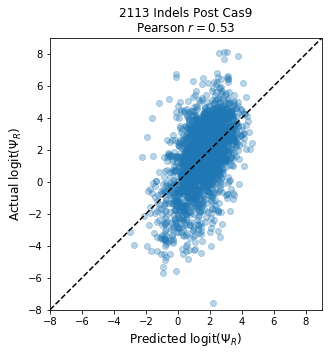

In [30]:
plot_logit(y_preds, y_actual)

## Figure 3

(0.5454517276355229, 4.22793069661529e-164)


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


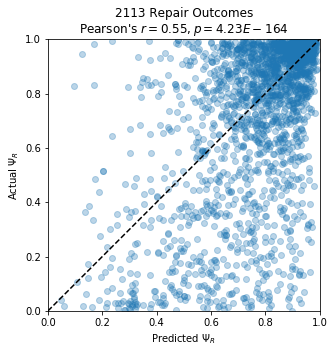

In [31]:
plot_interpretable(y_preds, y_actual)

In [32]:
len(set(y_gids))

1063

In [33]:
len(set(exp_gid_tid_map[g] for g in y_gids))

791

## S3 Fig

Number of gRNAs: 735
Number of WT PSI < 0.5: 5
Min WT PSI: 0.4545454545454546
Mean WT PSI (pre Cas9): 0.9091996368346703
Mean PSI_G (post Cas9): 0.6838906075443971


/data/gl/g6/wlouie/anaconda3/envs/skipguide_data_processing/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


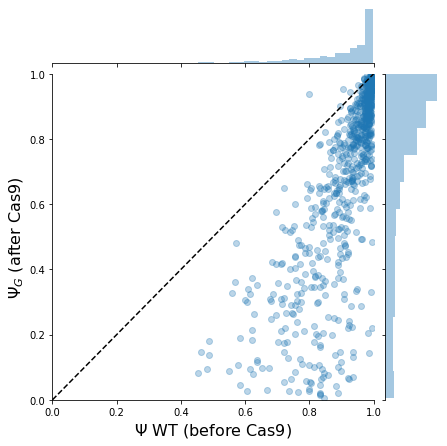

In [34]:
beforePSI_vs_afterPSI(gt_actual, gt_gids)

## Figure 4a

(0.6104039512230831, 1.5944790603975234e-109)
1063 1063
735 328


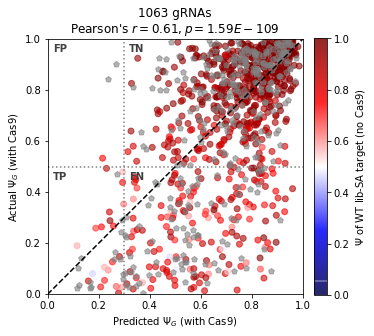

In [35]:
plot_normal(gt_preds, gt_actual, gt_gids)
plt.savefig(os.path.join(IMAGES_DIR, 'skipguide_preds.png'), dpi=300, bbox_inches='tight')
plt.show()

## Figure 4b

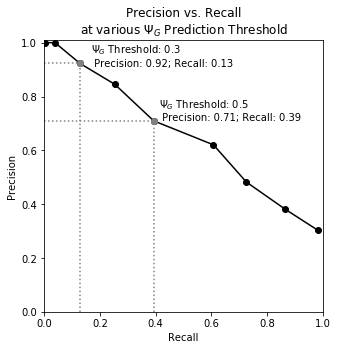

In [36]:
plot_precision_recall()

## S4 Fig (Perturbation Studies)

(0.009158332260919366, 0.7655121471425159)
1063 1063
735 328


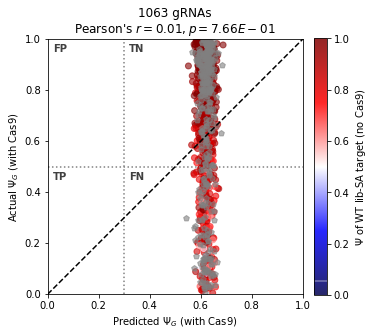

In [37]:
plot_normal(gt_preds_abwmmsplice, gt_actual_abwmmsplice, gt_gids_abwmmsplice)
plt.savefig(os.path.join(IMAGES_DIR, 'skipguide_abwmmsplice.png'), dpi=300, bbox_inches='tight')
plt.show()

(0.5437861104256172, 7.708099594374454e-83)
1063 1063
735 328


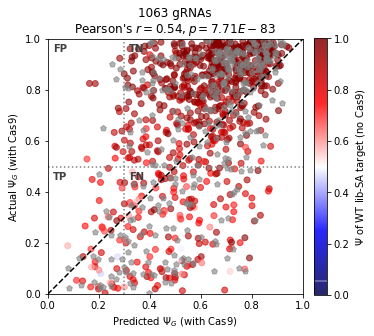

In [38]:
plot_normal(gt_preds_abindelphi, gt_actual_abindelphi, gt_gids_abindelphi)
plt.savefig(os.path.join(IMAGES_DIR, 'skipguide_abindelphi.png'), dpi=300, bbox_inches='tight')
plt.show()

(-0.008708280047914964, 0.7767220643270047)
1063 1063
735 328


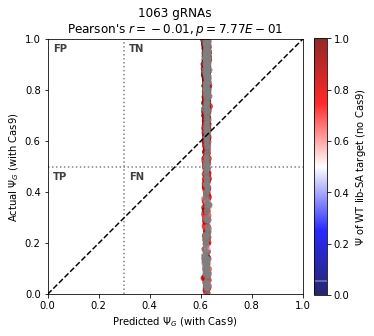

In [39]:
plot_normal(gt_preds_abboth, gt_actual_abboth, gt_gids_abboth)
plt.savefig(os.path.join(IMAGES_DIR, 'skipguide_abboth.png'), dpi=300, bbox_inches='tight')
plt.show()